Written by Bharath Ramsundar and Evan Feinberg

Copyright 2016, Stanford University


Computationally predicting molecular solubility through is useful for drug-discovery. In this tutorial, we will use the `deepchem` library to fit a simple statistical model that predicts the solubility of drug-like compounds. The process of fitting this model involves four steps:

1. Loading a chemical dataset, consisting of a series of compounds along with aqueous solubility measurements.
2. Transforming each compound into a feature vector $v \in \mathbb{R}^n$ comprehensible to statistical learning methods.
3. Fitting a simple model that maps feature vectors to estimates of aqueous solubility.
4. Visualizing the results.

We need to load a dataset of estimated aqueous solubility measurements [1] into deepchem. The data is in CSV format and contains SMILES strings, predicted aqueaous solubilities, and a number of extraneous (for our purposes) molecular properties. Here is an example line from the dataset:

|Compound ID|ESOL predicted log solubility in mols per litre|Minimum Degree|Molecular Weight|Number of H-Bond Donors|Number of Rings|Number of Rotatable Bonds|Polar Surface Area|measured log solubility in mols per litre|smiles|
|-----------|-----------------------------------------------|--------------|----------------|----------------------------|---------------|-------------------------|-----------------------------------------------------------------------|------|
|benzothiazole|-2.733|2|135.191|0|2|0|12.89|-1.5|c2ccc1scnc1c2|

Most of these fields are not useful for our purposes. The two fields that we will need are the "smiles" field and the "measured log solubility in mols per litre". The "smiles" field holds a SMILES string [2] that specifies the compound in question. Before we load this data into deepchem, we will load the data into python and do some simple preliminary analysis to gain some intuition for the dataset. 

In [ ]:
%autoreload 2
from deepchem.utils.save import load_from_disk

dataset_file= "../datasets/delaney-processed.csv"
dataset = load_from_disk(dataset_file)
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

To gain a visual understanding of compounds in our dataset, let's draw them using rdkit.

In [49]:
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import Image, HTML, display

def display_images(filenames):
    """Helper to pretty-print images."""
    imagesList=''.join(
        ["<img style='width: 140px; margin: 0px; float: left; border: 1px solid black;' src='%s' />"
         % str(s) for s in sorted(filenames)])
    display(HTML(imagesList))

num_to_display = 12
filenames = []
for i, data in dataset.iterrows():
    if i >= num_to_display:
        break
    filename = "test%d.png" % i
    Draw.MolToFile(Chem.MolFromSmiles(data["smiles"]), filename)
    filenames.append(filename)
display_images(filenames)

Analyzing the distribution of solubilities shows us a nice spread of data.

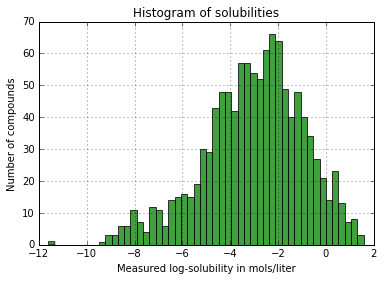

In [50]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

solubilities = np.array(dataset["measured log solubility in mols per litre"])
n, bins, patches = plt.hist(solubilities, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of solubilities')
plt.grid(True)
plt.show()


With our preliminary analysis completed, we return to the original goal of constructing a predictive statistical model of molecular solubility using `deepchem`. The first step in creating such a molecule is translating each compound into a vectorial format that can be understood by statistical learning techniques. This process is commonly called featurization. `deepchem` packages a number of commonly used featurization for user convenience. In this tutorial, we will use ECPF4 fingeprints [3].

`deepchem` offers an object-oriented API for featurization. To get started with featurization, we first construct a ```Featurizer``` object. `deepchem` provides the ```CircularFingeprint``` class (a subclass of ```Featurizer``` that performs ECFP4 featurization).


In [51]:
from deepchem.featurizers.fingerprints import CircularFingerprint

featurizers = [CircularFingerprint(size=1024)]

Now, let's perform the actual featurization. `deepchem` provides the ```DataFeaturizer``` class for this purpose. The ```featurize()``` method for this class loads data from disk and uses provided ```Featurizer```instances to transform the provided data into feature vectors. The method constructs an instance of class ```FeaturizedSamples``` that has useful methods, such as an iterator, over the featurized data.

In [52]:
import tempfile, shutil
from deepchem.featurizers.featurize import DataFeaturizer

#Make directories to store the raw and featurized datasets.
feature_dir = tempfile.mkdtemp()
samples_dir = tempfile.mkdtemp()

featurizer = DataFeaturizer(tasks=["measured log solubility in mols per litre"],
                            smiles_field="smiles",
                            compound_featurizers=featurizers)
featurized_samples = featurizer.featurize(dataset_file, feature_dir, samples_dir)

When constructing statistical models, it's necessary to separate the provided data into train/test subsets. The train subset is used to learn the statistical model, while the test subset is used to evaluate the learned model. In practice, it's often useful to elaborate this split further and perform a train/validation/test split. The validation set is used to perform model selection. Proposed models are evaluated on the validation-set, and the best performed model is at the end tested on the test-set.

Choosing the proper method of performing a train/validation/test split can be challenging. Standard machine learning practice 

Now, we conduct a train-test split. If you'd like, you can choose `splittype="scaffold"` instead to perform a train-test split based on Bemis-Murcko scaffolds.

In [9]:
splittype = "random"
train_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp()


train_samples, test_samples = featurized_samples.train_test_split(
    splittype, train_dir, test_dir)

We generate separate instances of the Dataset() object to hermetically seal the train dataset from the test dataset. This style lends itself easily to validation-set type hyperparameter searches, which we will illustate in a separate tutorial. 

In [14]:
from deepchem.utils.dataset import Dataset
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=featurizers, tasks=["label"])
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                       featurizers=featurizers, tasks=["label"])

The performance of many ML algorithms hinges greatly on careful data preprocessing. Deepchem comes standard with a few options for such preprocessing.

In [15]:
input_transforms = ["normalize", "truncate"]
output_transforms = ["normalize"]
train_dataset.transform(input_transforms, output_transforms)
test_dataset.transform(input_transforms, output_transforms)

Now, we're ready to do some learning! To set up a model, we will need: (a) a dictionary ```task_types``` that maps a task, in this case ```label```, i.e. the Ki, to the type of the task, in this case ```regression```. For the multitask use case, one will have a series of keys, each of which is a different task (Ki, solubility, renal half-life, etc.) that maps to a different task type (regression or classification).

To fit a deepchem model, first we instantiate one of the provided (or user-written) model classes. In this case, we have a created a convenience class to wrap around any ML model available in Sci-Kit Learn that can in turn be used to interoperate with deepchem. To instantiate an ```SklearnModel```, you will need (a) task_types, (b) model_params, another ```dict``` as illustrated below, and (c) a ```model_instance``` defining the type of model you would like to fit, in this case a ```RandomForestRegressor```.

In [17]:
task_types = {"label": "regression"}
model_params = {"data_shape": train_dataset.get_data_shape()}

from sklearn.ensemble import RandomForestRegressor
from deepchem.models.standard import SklearnModel
model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor())
model.fit(train_dataset)
model_dir = tempfile.mkdtemp()
model.save(model_dir)

In [19]:
from deepchem.utils.evaluate import Evaluator
evaluator = Evaluator(model, train_dataset, verbose=True)
with tempfile.NamedTemporaryFile() as train_csv_out:
  with tempfile.NamedTemporaryFile() as train_stats_out:
    df, r2score = evaluator.compute_model_performance(
        train_csv_out, train_stats_out)


Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7f9aeae9ac00>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7f9aeae9ab70>


In [21]:
r2score

,task_name,r2_score,rms_error
0,label,0.826262,0.939944


While we have computed three separate featurizations -- ECFP4, RDKitDescriptors, and NNScore -- in this example we choose to use the RDKitDescriptors featurization. This will serve as a baseline as you apply more advanced featurization schemes.

It is essential for many ML methods, depending on the data type, to perform preprocessing in order to attain optimal performance. Here, we choose to normalize and truncate the inputs (X, the featurized complexes) while normalizing the output (y, the binding affinities):

To recap, the initial dataset has now been featurized, split into train and test sets, and transformed. We are now ready to learn some chemistry! To warm up, let's apply a more traditional but quite robust statistical learning technique: random forests.

Now that we've fit an Random Forest Regressor on the data, let's evaluate its performance:

Let's compare this to performance with a deep neural network.

In [ ]:
from deepchem.models import Model

task_type = "regression"
model_params = {"activation": "relu",
              "dropout": 0.,
              "momentum": .9, "nesterov": False,
              "decay": 1e-4, "batch_size": 5,
              "nb_epoch": 10}
model_name = "singletask_deep_regressor"

nb_hidden_vals = [10, 100]
learning_rate_vals = [.01, .001]
init_vals = ["glorot_uniform"]
hyperparameters = [nb_hidden_vals, learning_rate_vals, init_vals]
hyperparameter_rows = []
for hyperparameter_tuple in itertools.product(*hyperparameters):
    nb_hidden, learning_rate, init = hyperparameter_tuple
    model_params["nb_hidden"] = nb_hidden
    model_params["learning_rate"] = learning_rate
    model_params["init"] = init

    model_dir = tempfile.mkdtemp()

    r2_score = create_and_eval_model(train_dataset, test_dataset, task_type,
                                     model_params, model_name, model_dir, tasks)

    print("%s: %s" % (hyperparameter_tuple, r2_score))
    hyperparameter_rows.append(list(hyperparameter_tuple) + [r2_score])

    shutil.rmtree(model_dir)

hyperparameter_df = pd.DataFrame(hyperparameter_rows,
                               columns=('nb_hidden', 'learning_rate',
                                        'init', 'r2_score'))

hyperparameter_df

In [ ]:
[1] John S. Delaney. ESOL: Estimating aqueous solubility directly from molecular structure. Journal
of Chemical Information and Computer Sciences, 44(3):1000–1005, 2004.

[2] Anderson, Eric, Gilman D. Veith, and David Weininger. SMILES, a line notation and computerized
interpreter for chemical structures. US Environmental Protection Agency, Environmental Research Laboratory, 1987.

[3] Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." Journal of chemical information
and modeling 50.5 (2010): 742-754.
    
[4] Van Der Walt, Stefan, S. Chris Colbert, and Gael Varoquaux.
"The NumPy array:a structure for efficient numerical computation." Computing in Science & Engineering 13.2 (2011): 22-30.